# Objectif de ce notebook
1. Evaluer la qualité des datasets générés par 0_generate_dataset.ipynb
2. Explorer les données des datasets

# Importer toutes les libraries nécessaires avec la cellule suivante

In [1]:
import numpy as np
import pandas as pd
import random
import string

# ****Modélisation et prédiction****
## Objectifs
- Déterminer le modèle le plus adéquate pour prédire la note d'un item
- Tester plusieurs modèles, les évaluer et garder le meilleur modèle

## 1. Modèles de regression
## 1.1. RandomForestRegressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Génération des données
df = pd.read_csv("../data/processed/item_dataset.csv")

# 2. Sélection des variables numériques
features = [
    "nb_stats", "nb_perfect_lines", "nb_high_ratio",
    "total_weight", "exo_weight", "over_weight",
    "avg_ratio", "nb_essential_stats_ratio",
    "nb_secondary_stats_ratio", "nb_heavy_stats_ratio",
    "nb_resistance_pourcent_ratio", "nb_dommage_pourcent_ratio"
]
target = "note"

X = df[features]
y = df[target]

# 3. Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Prédictions
y_pred = model.predict(X_test)

# 6. Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.3f}")

KeyError: "['nb_high_ratio', 'over_weight'] not in index"

## 1.2. GradientBoostingRegressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Générer les données
df = pd.read_csv("../data/processed/item_dataset.csv")

# Features utilisées pour l'entraînement
features = ["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight"]
target = "note"

X = df[features]
y = df[target]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Prédiction
y_pred = model.predict(X_test)

# Évaluation
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"GradientBoostingRegressor → RMSE : {rmse:.2f}")
print(f"GradientBoostingRegressor → R² : {r2:.3f}")

GradientBoostingRegressor → RMSE : 8.41
GradientBoostingRegressor → R² : 0.397


### 1.3. Bilan des modèles de regression
On remarque que pour les deux premiers modèles, le RMSE semble correcte mais l'indicateur R2 semble indiquer que les  modèles ne prédisent pas correctement le comportement souhaité

On va donc vérifier l'importance des features au sein du dataset

In [ ]:
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f"{feat} : {imp:.3f}")


nb_stats : 0.346
nb_perfect_lines : 0.427
nb_high_ratio : 0.091
total_weight : 0.083
exo_weight : 0.002
over_weight : 0.051


On remarque que le nb_perfect_lines joue un grand rôle dans l'évaluation ce qui est normal
Il faut donc trouver une alternative pour enrichir les features ou simplifier la prédiction

Remarque : essayons de classifier nos résultats afin de faire de la classification

## 2. Modèle par classification
## 2.1. RandomForestClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00         7
  jet mauvais       0.40      0.35      0.37       519
    jet moyen       0.50      0.49      0.50      1045
  jet parfait       0.00      0.00      0.00        28
 très bon jet       0.65      0.70      0.68      1401

     accuracy                           0.56      3000
    macro avg       0.31      0.31      0.31      3000
 weighted avg       0.55      0.56      0.55      3000

Matrice de confusion :
[[  0   1   2   0   4]
 [  0 181 198   0 140]
 [  1 177 515   1 351]
 [  0   0   1   0  27]
 [  3  91 315   5 987]]


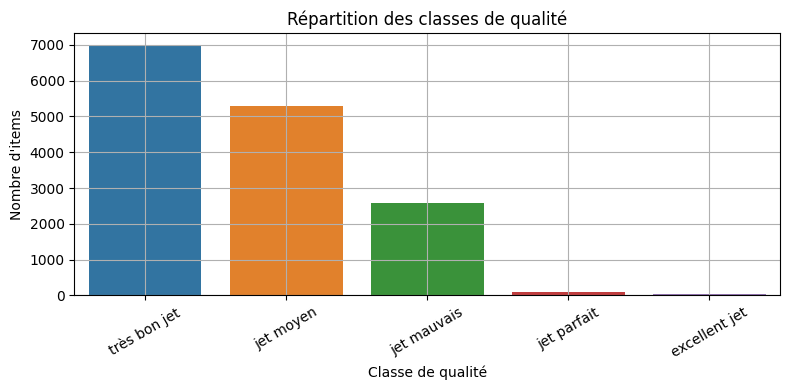

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On remarque qu'il y a beaucoup trop d'item avec un très bon jet.

On va rééquilibrer le modèle pour qu'il se foacalise davantage sur les classes minoritaires

## 2.2. RandomForestClassifier Balanced

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00         7
  jet mauvais       0.40      0.34      0.37       519
    jet moyen       0.50      0.50      0.50      1045
  jet parfait       0.00      0.00      0.00        28
 très bon jet       0.66      0.71      0.68      1401

     accuracy                           0.57      3000
    macro avg       0.31      0.31      0.31      3000
 weighted avg       0.55      0.57      0.56      3000

Matrice de confusion :
[[  0   0   2   0   5]
 [  0 179 208   0 132]
 [  1 173 523   0 348]
 [  0   0   1   0  27]
 [  2  95 306   4 994]]


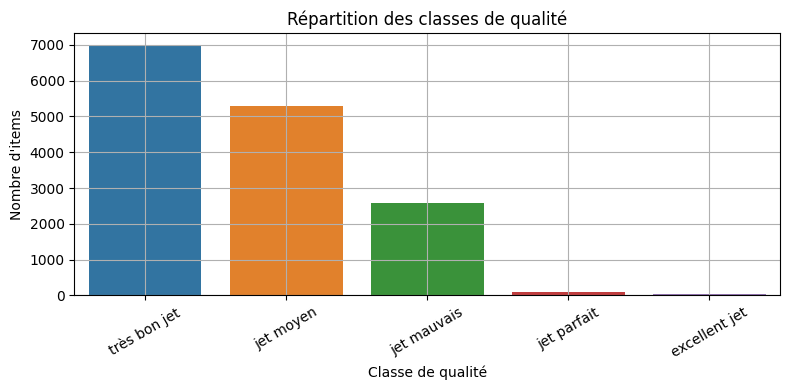

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.3. GradientBoostingClassifier

Classification Report (multi-classes) :
               precision    recall  f1-score   support

excellent jet       0.00      0.00      0.00         7
  jet mauvais       0.68      0.25      0.36       519
    jet moyen       0.52      0.59      0.55      1045
  jet parfait       0.33      0.04      0.06        28
 très bon jet       0.67      0.78      0.72      1401

     accuracy                           0.61      3000
    macro avg       0.44      0.33      0.34      3000
 weighted avg       0.62      0.61      0.59      3000

Matrice de confusion :
[[   0    0    0    0    7]
 [   0  128  270    1  120]
 [   0   54  618    0  373]
 [   0    0    1    1   26]
 [   2    7  302    1 1089]]


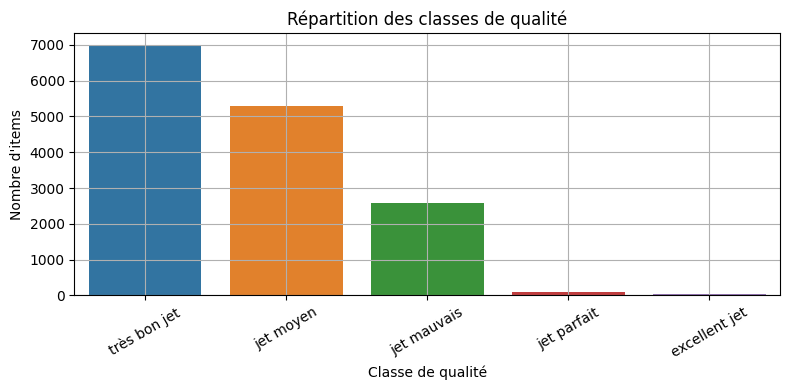

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 95:
        return "excellent jet"
    elif note > 85:
        return "très bon jet"
    elif note > 70:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Enrichissement des features
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.columns.str.contains("dommage") & full_df.notna().any()
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features numériques enrichies
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight", "exo_weight", "over_weight", "perfect_ratio", "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Évaluation
print("Classification Report (multi-classes) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

# Visualisation de la répartition des classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=full_df, x="qualité", order=full_df["qualité"].value_counts().index)
plt.title("Répartition des classes de qualité")
plt.xlabel("Classe de qualité")
plt.ylabel("Nombre d'items")
plt.xticks(rotation=30)
plt.grid(True)
plt.tight_layout()
plt.show()


On va simplifier la classification

## 2.4. GradientBoostingClassifier simplified classes

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Le dataset est supposé avoir été généré dans une cellule précédente
# Exemple : df = generate_dataset()
full_df = df.copy()

# Ajout d'une colonne de classe multi-niveaux selon la note
def label_item(note):
    if note == 100:
        return "jet parfait"
    elif note > 90:
        return "très bon jet"
    elif note > 75:
        return "jet moyen"
    else:
        return "jet mauvais"

full_df["qualité"] = full_df["note"].apply(label_item)

# Ajout des features dérivées manquantes
full_df["perfect_ratio"] = full_df["nb_perfect_lines"] / full_df["nb_stats"]
full_df["has_dommage"] = full_df.apply(lambda row: any("dommage" in col and row[col] > 0 for col in full_df.columns), axis=1)
full_df["has_dommage_elementaire"] = full_df.apply(lambda row: any(stat in row and row[stat] > 0 for stat in ["dommage_feu", "dommage_air", "dommage_eau", "dommage_terre", "dommage_neutre"]), axis=1)
full_df["has_resistance_%"] = full_df.apply(lambda row: any("résistance_" in stat and "%" in stat and row[stat] > 0 for stat in row.index if stat in row), axis=1)

# Sélection des features
X = full_df[["nb_stats", "nb_perfect_lines", "nb_high_ratio", "total_weight",
             "exo_weight", "over_weight", "perfect_ratio",
             "has_dommage", "has_dommage_elementaire", "has_resistance_%"]]
y = full_df["qualité"]

# Split
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=10, random_state=42)
clf.fit(df_train, y_train)

# Prédiction
y_pred = clf.predict(df_test)

# Évaluation
print("Classification Report (simplifié) :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Classification Report (simplifié) :
              precision    recall  f1-score   support

 jet mauvais       0.55      0.34      0.42       696
   jet moyen       0.67      0.83      0.74      1732
 jet parfait       0.00      0.00      0.00        28
très bon jet       0.58      0.44      0.50       544

    accuracy                           0.64      3000
   macro avg       0.45      0.40      0.41      3000
weighted avg       0.62      0.64      0.62      3000

Matrice de confusion :
[[ 234  427    0   35]
 [ 163 1446    2  121]
 [   1    8    0   19]
 [  25  280    2  237]]
